In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from osgeo import gdal
import math as m
import matplotlib.colors as colors
import scipy.ndimage as nd
import xarray as xr

%matplotlib inline

/home/minchew/globals/anaconda3/envs/ice-tides/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from strain_codes import *

# Basic Instructions

This is a simple notebook to derive strain rate fields from x and y velocity fields. Demonstrated here is Jeremie Mouginot's Antarctic ice velocity over Crary Ice Rise

data source: https://www.mdpi.com/2072-4292/9/4/364

In [3]:
# open velocity dataset and split into vx and vy components
ds = xr.open_dataset(('/home/jdmill/antarctica_ice_velocity_450m_v2.nc'))
vx_ = np.asarray(ds.VX)
vy_ = np.asarray(ds.VY)
lat_ = np.asarray(ds.lat)
lon_ = np.asarray(ds.lon)

In [4]:
#use plt.imshow(vx) to crop dimensions to some region that is both computationally efficient and small enough!

vx = vx_[7300:8100,5000:6600]
vy = vy_[7300:8100,5000:6600]
lat = np.flip((lat_[7300:8100,5000:6600]).T)
lon = np.flip((lon_[7300:8100,5000:6600]).T)-360

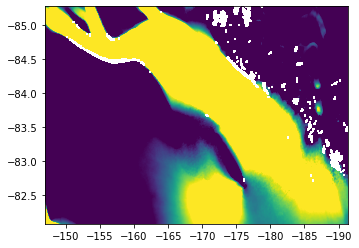

In [5]:
#plot our ROI in lat/lon, mainly for figure making
plt.imshow(vx, vmin=10,vmax=100,extent = [lon[-1,0], lon[0,0],  lat[0,0], lat[0,-1]], aspect=10)

In [6]:
#compute strain rates *contained in the dictionary crary* and the strain rate tensor *DR* from Bryan Riel's iceutils
#(this code is a slightly simplified version to mess with the window size for my personal use)
# strain rates spit out in values of per year

crary, DR = compute_strains(vx, vy, 450, -450, rotate=True, grad_method='numpy',inpaint=False)

#compute the eigenvalues and eigenvectors
eigvalsR, eigvecsR = np.linalg.eigh(DR.T)

princ1stR = eigvalsR[:,1].reshape(vx.shape)
princ2ndR = eigvalsR[:,0].reshape(vx.shape)
ev01R = eigvecsR[:,0,1].reshape(vx.shape)
ev00R = eigvecsR[:,0,0].reshape(vx.shape)
ev11R = eigvecsR[:,1,1].reshape(vx.shape)
ev10R = eigvecsR[:,1,0].reshape(vx.shape)
eigvals, eigvecs = np.linalg.eigh(DR.T)

In [7]:
vx.shape

(800, 1600)

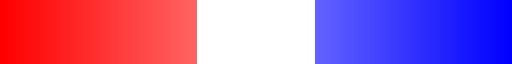

In [8]:
# colormap where > 0 is blue (extension) and < 0 is red (compression), can remove 

import matplotlib.cm as cm
viridis = cm.get_cmap('bwr', 256)
newcolors = viridis(np.linspace(0, 1, 256))
beep = cm.get_cmap('bone', 2)
beep = beep(np.linspace(0, 1, 100))
newcoalors2 = newcolors[0:50, :] 
greys = beep[70:,:]
newcolors3 = newcolors[206:, :]
newcmp = colors.ListedColormap(np.vstack((newcolors3[::-1],greys,newcoalors2[::-1])))
newcmp

In [9]:
# plot cropped region around Brunt's north rift in lat/lon S. polar stereo   [ lon[0,0],  lat[0,0], lat[0,-1]]
lon = np.linspace(-1*lon[-1,0], -1*lon[0,0], len(vx[1,:]))
lon = -1*(lon)
lat = np.linspace(lat[0,0],lat[0,-1],len(vx[:,1]))


la,lo= np.meshgrid(lon,lat)

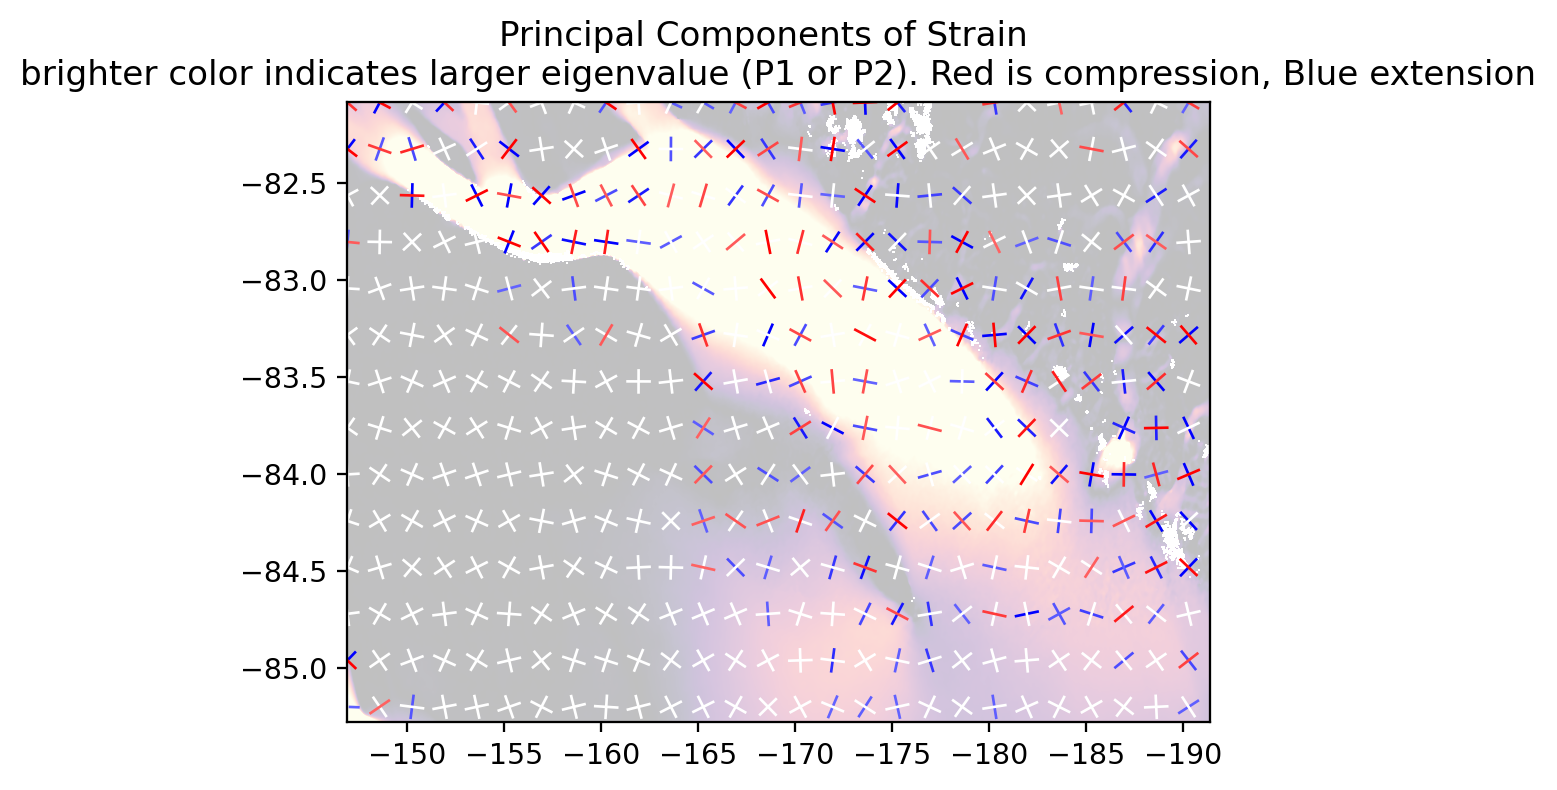

In [53]:
fig, axs = plt.subplots(ncols=1,dpi=205)

i = 60
j = 60

velocity = np.sqrt(vx**2 + vx**2)

sqrt = ((np.sqrt(vx[::i,::j]**2 + vx[::i,::j]**2)))

# velocity in meters per year
axs.imshow(nd.median_filter(velocity,5), vmin = 0, vmax = 3e2, cmap='magma', alpha=0.25,
           extent = [lon[0], lon[-1], lat[-1], lat[0]], aspect=10)

# first principal component 
axs.quiver(la[::i,::j],lo[::i,::j],
                ev00R[::i,::j], 
                ev01R[::i,::j], np.ma.masked_where(sqrt > 40000.,princ1stR[::i,::j]),
                pivot='middle',headaxislength=0, headlength=0,angles='uv',
                cmap=newcmp,norm=colors.TwoSlopeNorm(vmin=-.01, vcenter=0,vmax=.01))

# second principal component of strain
axs.quiver(la[::i,::j],lo[::i,::j],
                ev10R[::i,::j],
                ev11R[::i,::j], np.ma.masked_where(sqrt > 40000.,princ2ndR[::i,::j]),
                pivot='middle',headaxislength=0, headlength=0,angles='uv',
                cmap=newcmp,norm=colors.TwoSlopeNorm(vmin=-.01, vcenter=0,vmax=.01))

#axs.axis('off')
plt.suptitle("Principal Components of Strain")
plt.title('brighter color indicates larger eigenvalue (P1 or P2). Red is compression, Blue extension')
plt.show()